Police crime data for San Francisco can be obtained from: https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783

The strategy for data processing and features:

1. Select: Incident Date, Incident Category

2. Handling Missing Values:
For Incident Category rows with missing values will be dropped or filled with "Unkown"

3. Data Transformation:
Incident Date will be converted to a datetime object, and additional time-based features such as the day of the week, month, and year will be extracted.

4. Feature Engineering:
Aggregate incidents daily, count the number of incidents of each type.
Calculate lag features to incorporate historical data, such as the number of incidents in the previous days.
Define a hotspot based on whether the next day’s incidents exceed one standard deviation above the mean of the previous 60 days
5. Preparing the Target Variable:
The target variable will be whether the next day is a hotspot, defined based on the criteria

In [12]:
import pandas as pd
import numpy as np

In [13]:
# make sure to install this package before running:
#pip install sodapy

## Access the dataset via API

Currently works without a token. It queries only 2000 records. We need to connect with a token so we can query every night. This dataset is updated every night at 10pm.

In [14]:
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.sfgov.org", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.sfgov.org,
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("wg3w-h783", limit=2000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [15]:
results_df.head()

,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,row_id,incident_id,incident_number,report_type_code,...,latitude,longitude,point,:@computed_region_26cr_cadq,:@computed_region_qgnn_b9vv,:@computed_region_jwn9_ihcz,:@computed_region_h4ep_8xdi,:@computed_region_nqbw_i6c3,:@computed_region_n4xg_c4py,:@computed_region_jg9y_a9du
0,2023-03-13T23:41:00.000,2023-03-13T00:00:00.000,23:41,2023,Monday,2023-03-13T23:41:00.000,125373607041,1253736,230167874,VS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-03-01T05:02:00.000,2023-03-01T00:00:00.000,05:02,2023,Wednesday,2023-03-11T15:40:00.000,125379506374,1253795,236046151,II,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-03-13T13:16:00.000,2023-03-13T00:00:00.000,13:16,2023,Monday,2023-03-13T13:17:00.000,125357107041,1253571,220343896,VS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-03-13T10:59:00.000,2023-03-13T00:00:00.000,10:59,2023,Monday,2023-03-13T11:00:00.000,125355107041,1253551,230174885,VS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-03-14T18:44:00.000,2023-03-14T00:00:00.000,18:44,2023,Tuesday,2023-03-14T18:45:00.000,125402407041,1254024,230176728,VS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Load the full CSV dataset. Last download 11/1/2023

In [16]:
# Load the data
file_path = 'data/Police_Department_Incident_Reports__2018_to_Present_20231101.csv'
data = pd.read_csv(file_path)

# EDA

In [17]:
data.columns

Index(['Incident Datetime', 'Incident Date', 'Incident Time', 'Incident Year',
       'Incident Day of Week', 'Report Datetime', 'Row ID', 'Incident ID',
       'Incident Number', 'CAD Number', 'Report Type Code',
       'Report Type Description', 'Filed Online', 'Incident Code',
       'Incident Category', 'Incident Subcategory', 'Incident Description',
       'Resolution', 'Intersection', 'CNN', 'Police District',
       'Analysis Neighborhood', 'Supervisor District',
       'Supervisor District 2012', 'Latitude', 'Longitude', 'Point',
       'Neighborhoods', 'ESNCAG - Boundary File',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'Civic Center Harm Reduction Project Boundary',
       'HSOC Zones as of 2018-06-05', 'Invest In Neighborhoods (IIN) Areas',
       'Current Supervisor Districts', 'Current Police Districts'],
      dtype='object')

### Longitude and Latitude are missing. A lot of information is missing. I wonder why?

In [18]:
data.head()

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,Point,Neighborhoods,ESNCAG - Boundary File,Central Market/Tenderloin Boundary Polygon - Updated,Civic Center Harm Reduction Project Boundary,HSOC Zones as of 2018-06-05,Invest In Neighborhoods (IIN) Areas,Current Supervisor Districts,Current Police Districts
0,2023/03/13 11:41:00 PM,2023/03/13,23:41,2023,Monday,2023/03/13 11:41:00 PM,125373607041,1253736,230167874,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023/03/01 05:02:00 AM,2023/03/01,05:02,2023,Wednesday,2023/03/11 03:40:00 PM,125379506374,1253795,236046151,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023/03/13 01:16:00 PM,2023/03/13,13:16,2023,Monday,2023/03/13 01:17:00 PM,125357107041,1253571,220343896,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023/03/13 10:59:00 AM,2023/03/13,10:59,2023,Monday,2023/03/13 11:00:00 AM,125355107041,1253551,230174885,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023/03/14 06:44:00 PM,2023/03/14,18:44,2023,Tuesday,2023/03/14 06:45:00 PM,125402407041,1254024,230176728,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#count NAs in Latitude
#data[["Latitude"]].isna().sum()

#Intersection is a cool feature but most of the data is missing?!
data[["Intersection"]].isna().sum()


Intersection    42876
dtype: int64

# Data Management

In [20]:
# define a function to calculate hotspots --
# currently calculates the mean and standard deviation for the last 60 days
# and if 
def calculate_hotspot(data):
    # Calculate rolling mean and standard deviation for the past 60 days
    mean_60_days = data['Total_Incidents_All'].rolling(window=60, min_periods=1).mean().shift(1)
    std_60_days = data['Total_Incidents_All'].rolling(window=60, min_periods=1).std().shift(1)

    # Shift the total incidents by one day to compare with the next day
    next_day_incidents = data['Total_Incidents_All'].shift(-1)

    # Calculate the hotspot based on the following condition
    hotspot = (next_day_incidents > (mean_60_days + std_60_days)).astype(int)

    return hotspot

# Selecting relevant columns and handling missing values
selected_columns = ['Incident Date', 'Incident Category']
data_selected = data[selected_columns].copy()
data_selected['Incident Category'].fillna('Unknown', inplace=True)  # Handling missing Incident Category as 'Unknown'

# Data transformation and feature engineering
data_selected['Incident Date'] = pd.to_datetime(data_selected['Incident Date'])

# Aggregating incidents daily, counting the number of incidents of each type
daily_totals = data_selected.groupby('Incident Date')['Incident Category'].value_counts().unstack(fill_value=0)

# Creating a column for the total number of incidents each day
daily_totals['Total_Incidents_All'] = daily_totals.sum(axis=1)

# Applying the function to calculate the 'Hotspot' column
daily_totals['Hotspot'] = calculate_hotspot(daily_totals)

# Number of days to lag
lags = 7

# Creating lag features for the total number of incidents
for lag in range(1, lags+1):
    daily_totals[f'Incidents_Lag{lag}'] = daily_totals['Total_Incidents_All'].shift(lag)

# Dropping rows with NaN values introduced by lagging
daily_totals.dropna(inplace=True)

# Adding temporal features
daily_totals['Day_of_Week'] = daily_totals.index.dayofweek
daily_totals['Month'] = daily_totals.index.month



# PLOTS

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

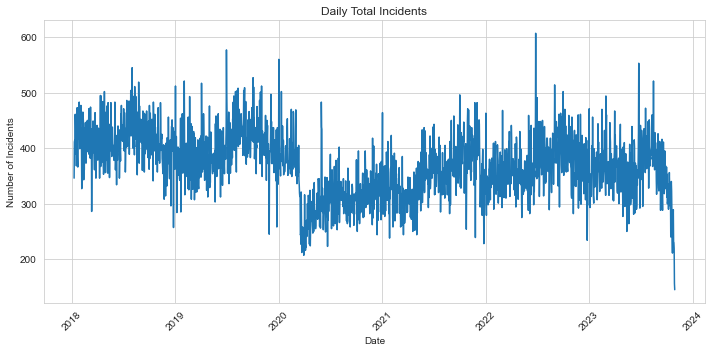

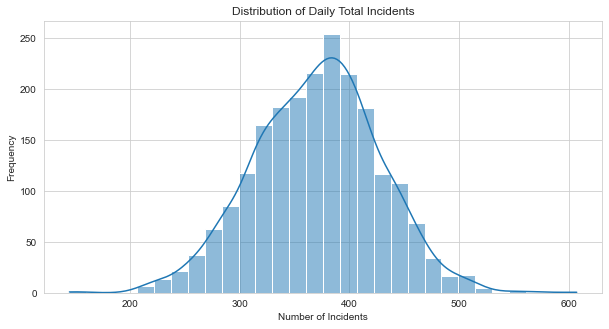

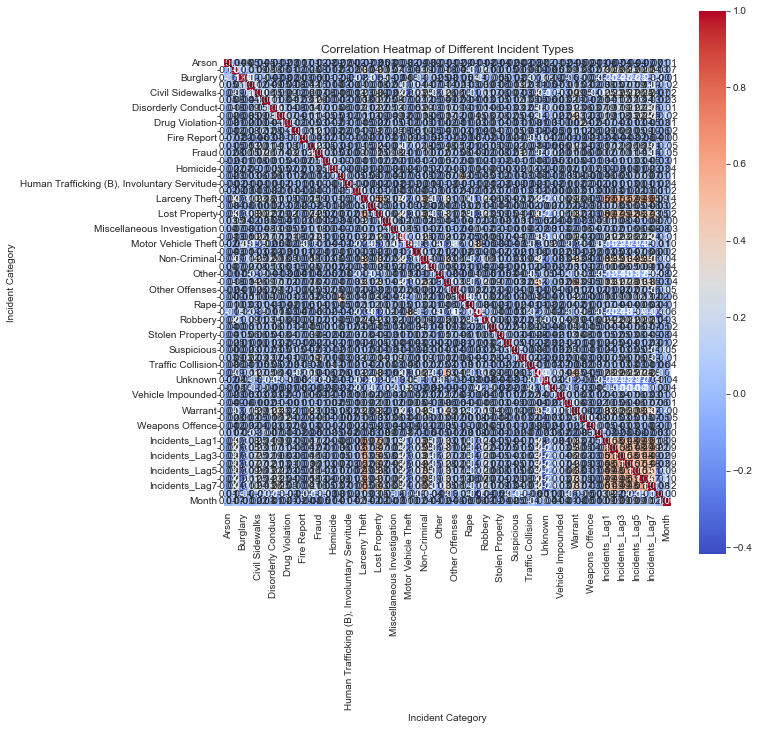

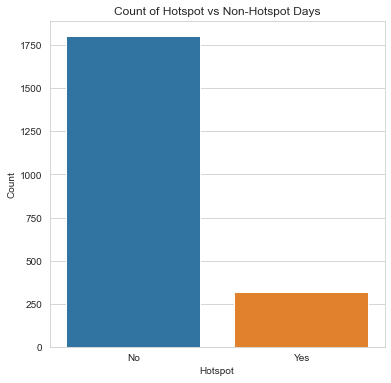

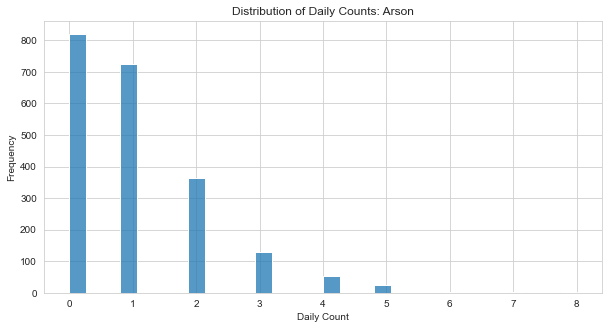

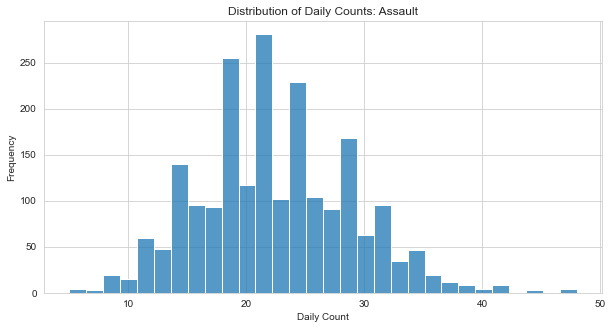

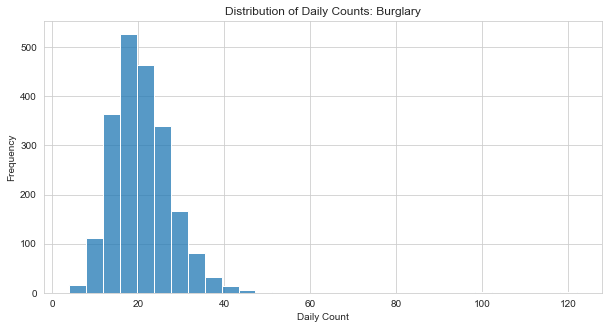

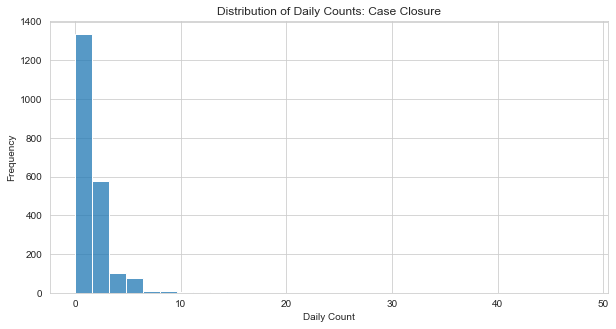

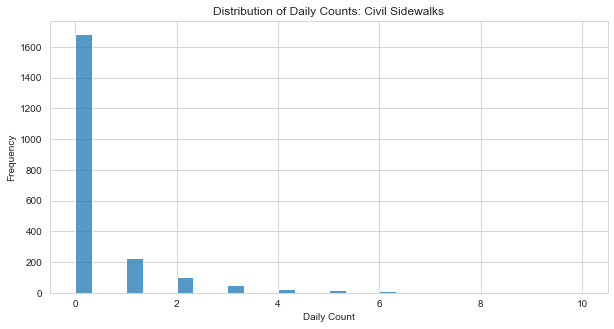

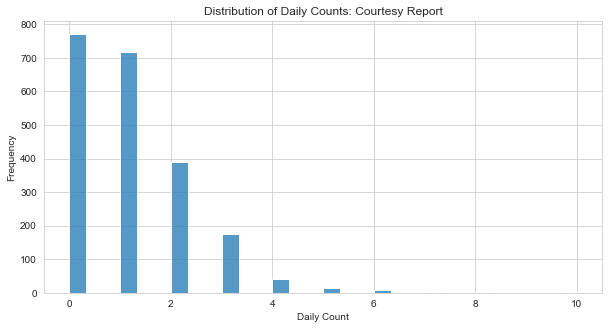

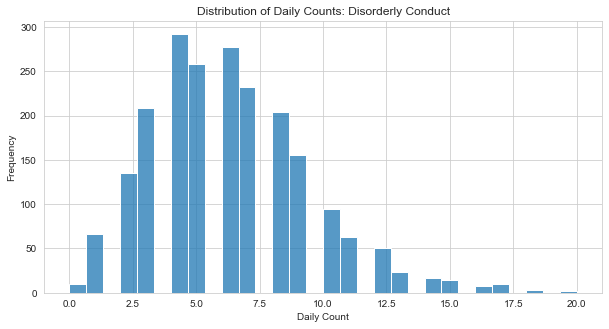

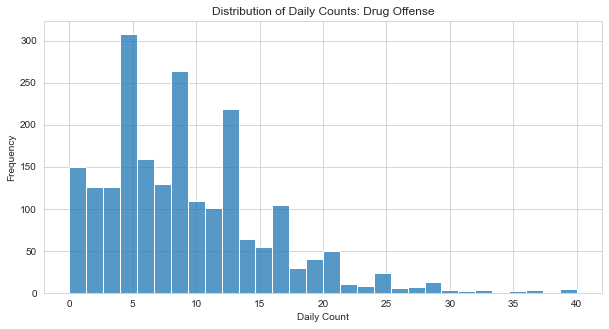

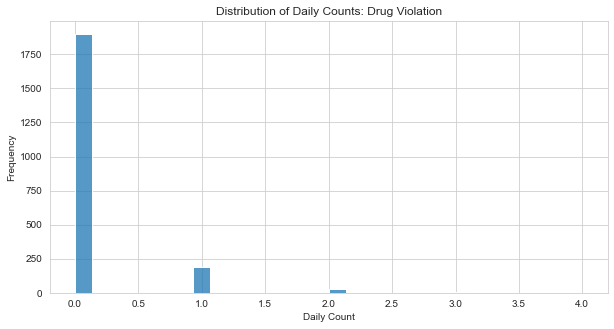

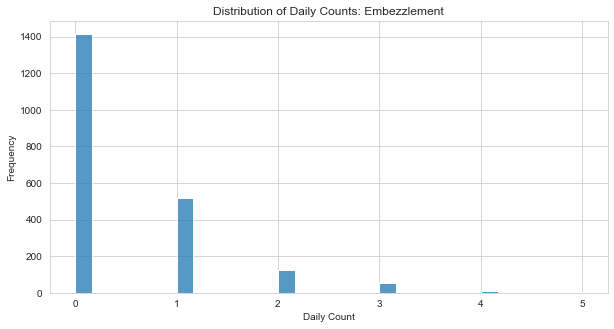

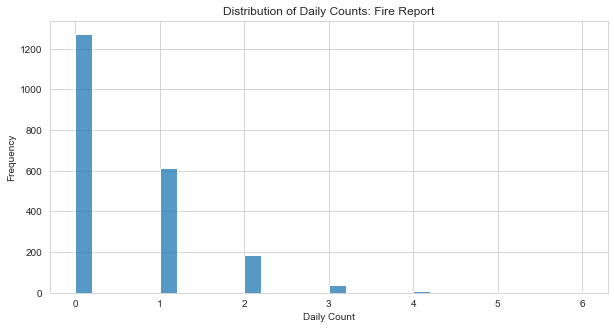

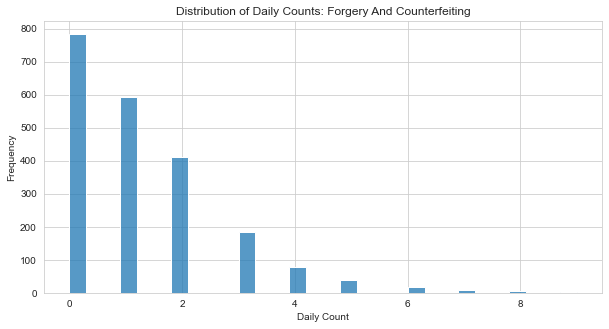

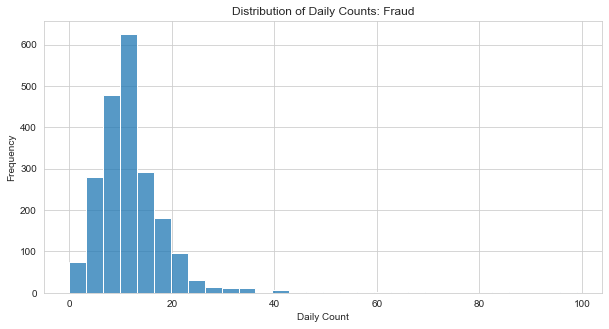

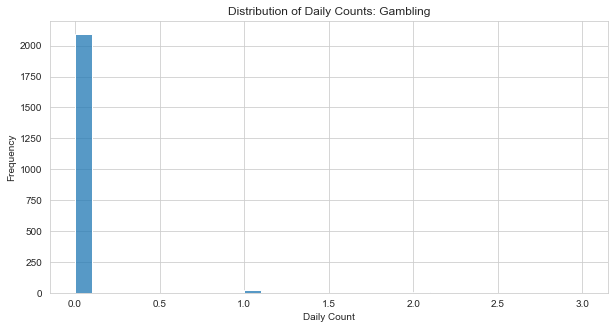

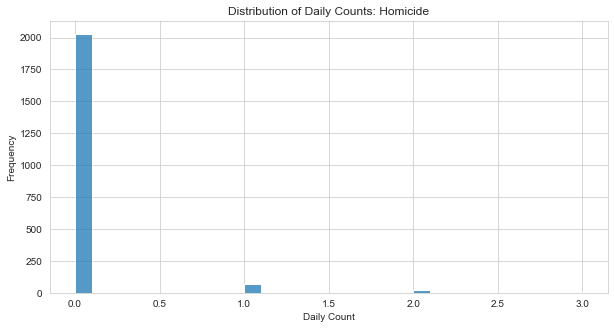

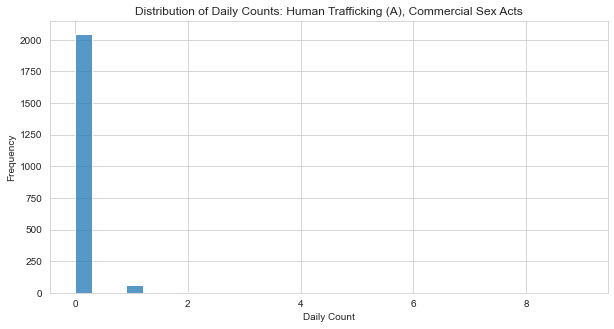

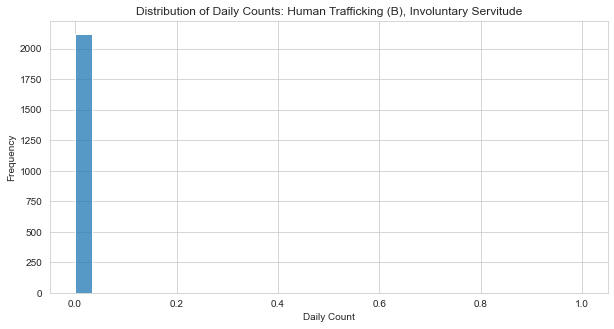

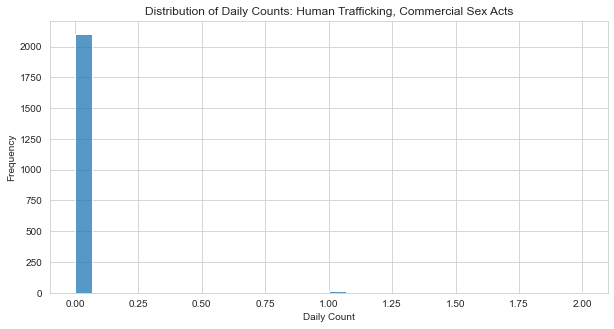

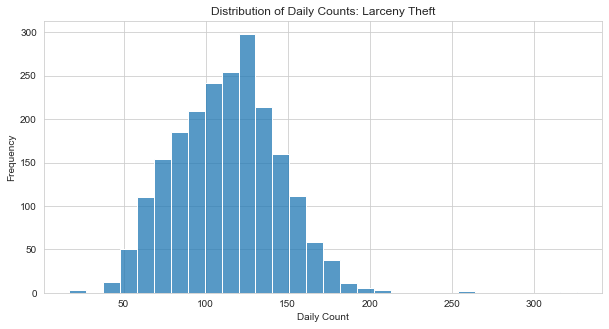

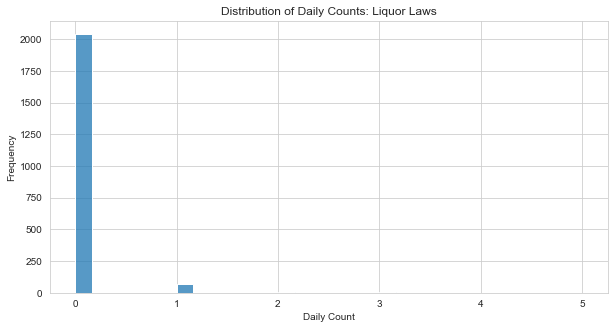

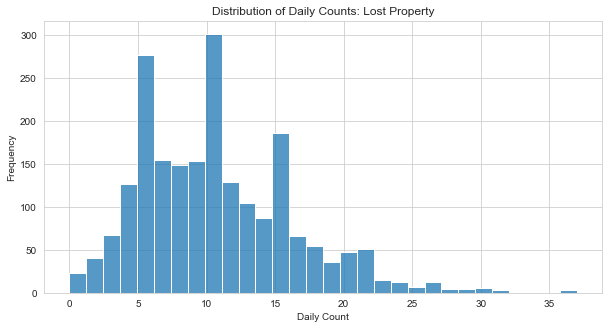

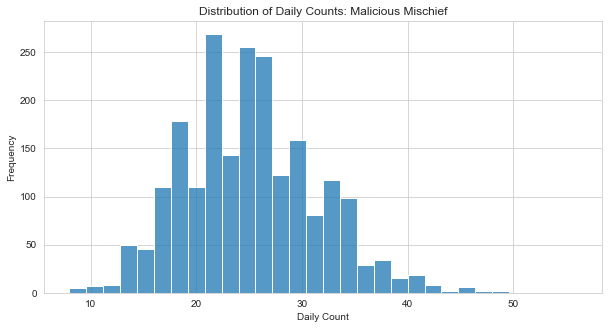

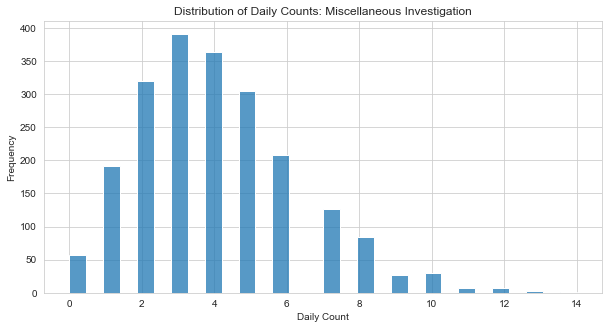

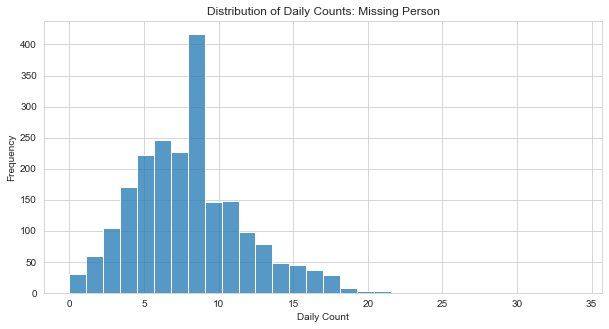

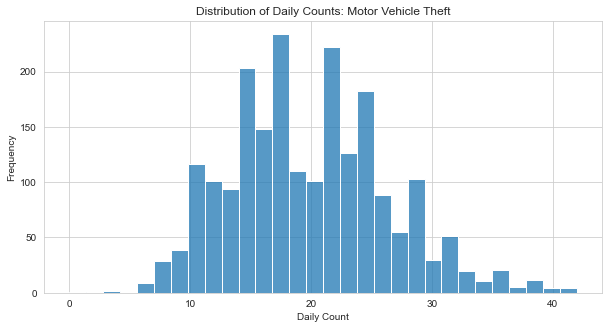

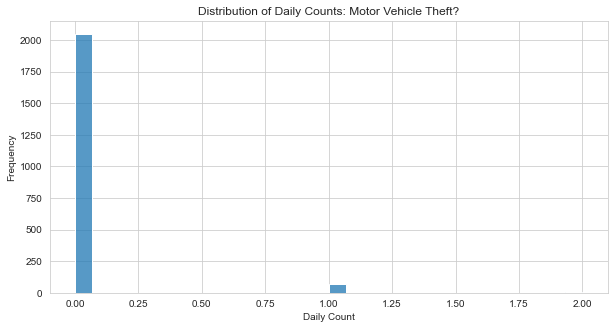

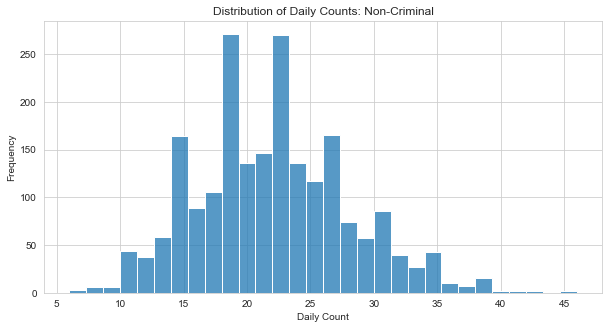

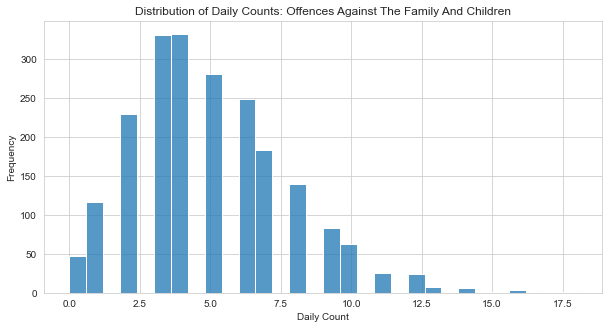

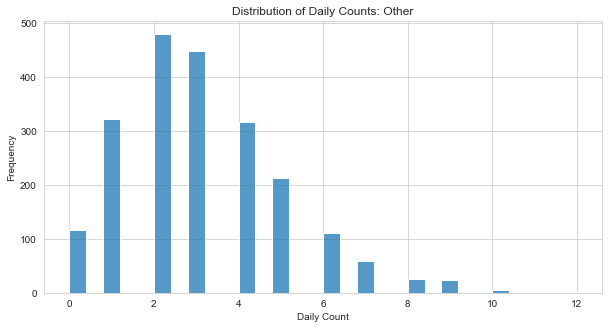

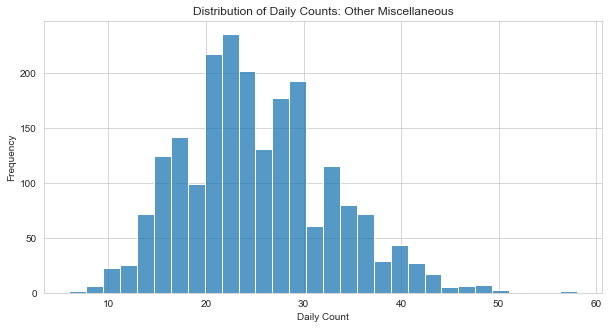

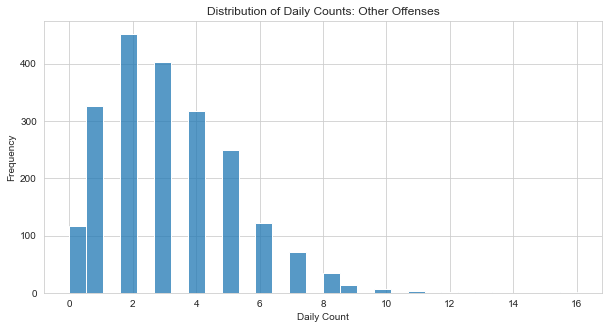

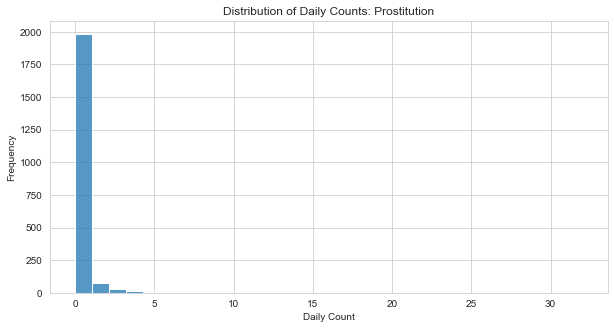

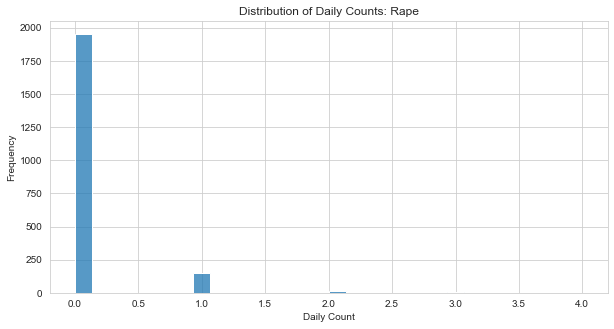

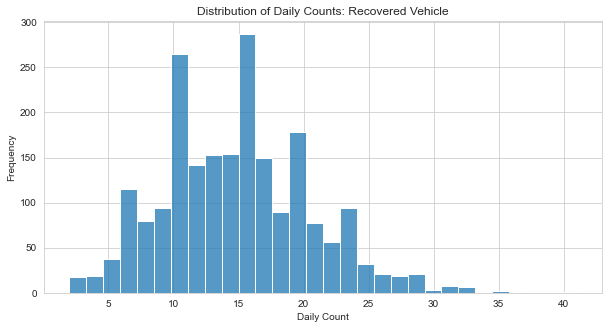

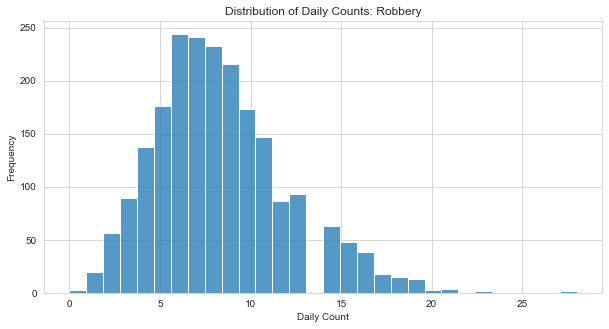

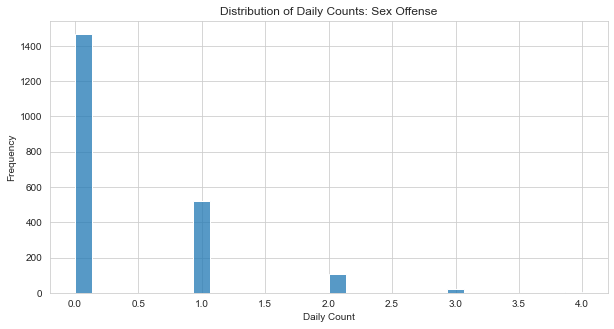

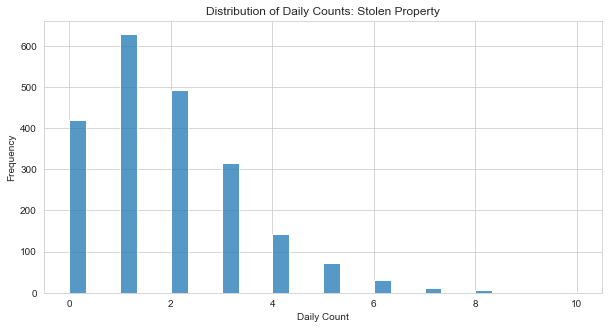

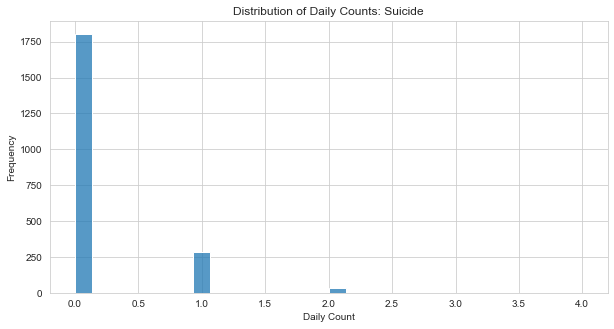

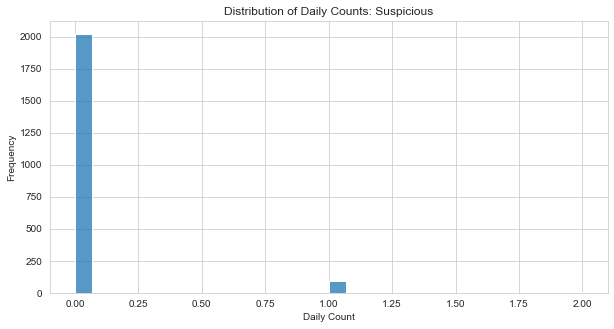

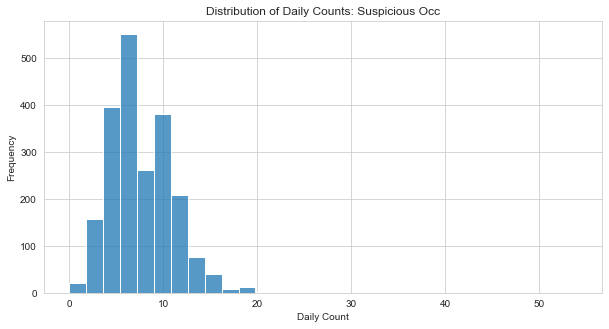

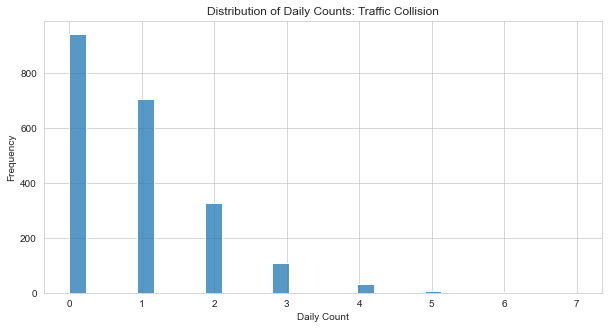

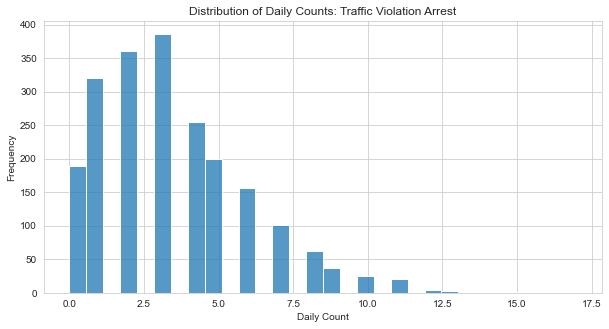

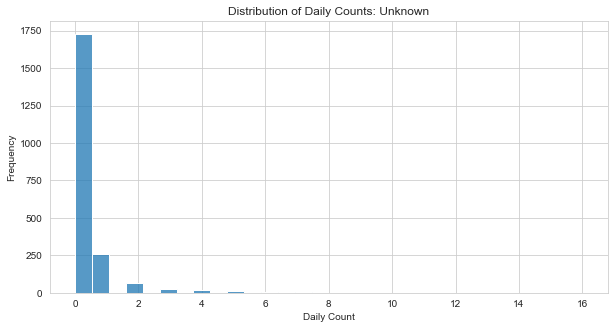

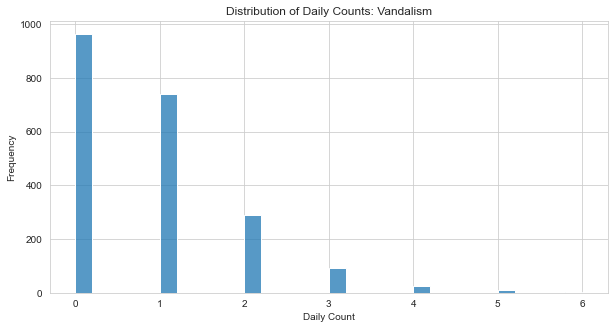

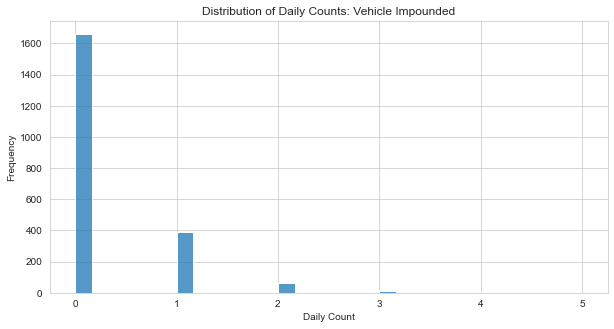

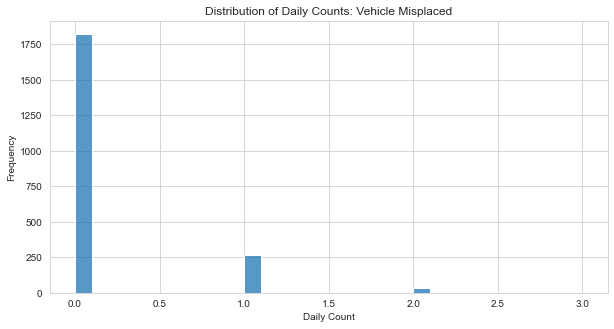

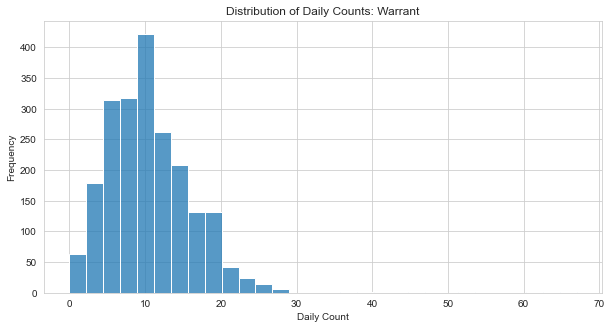

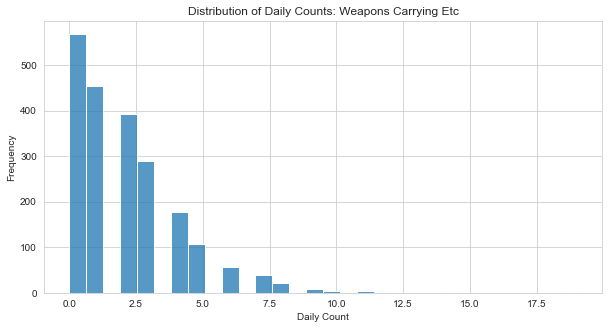

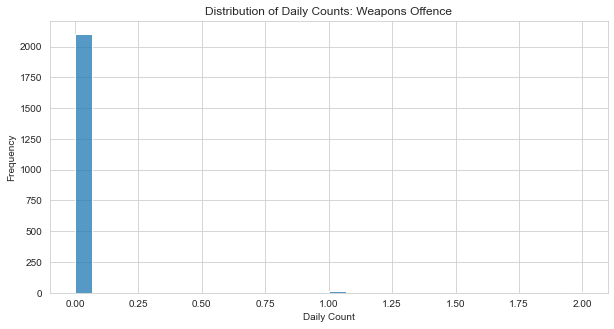

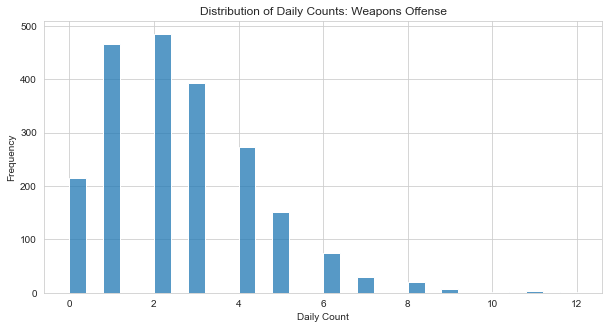

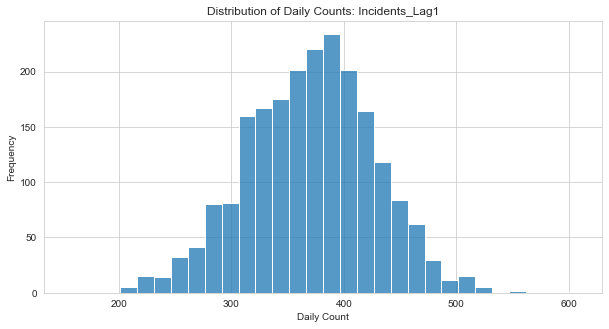

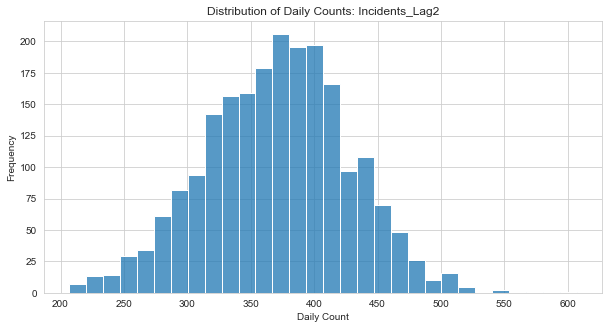

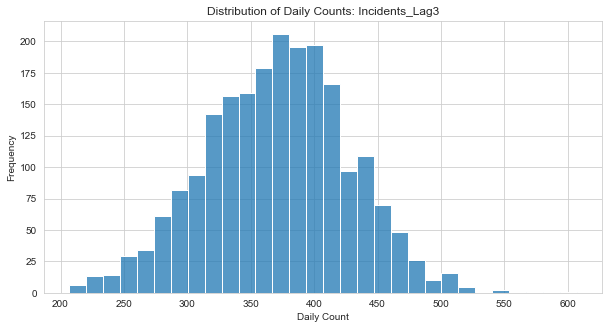

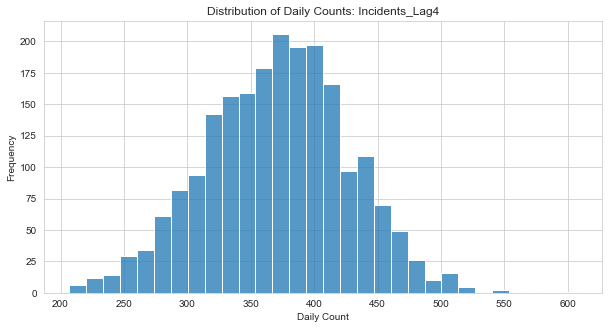

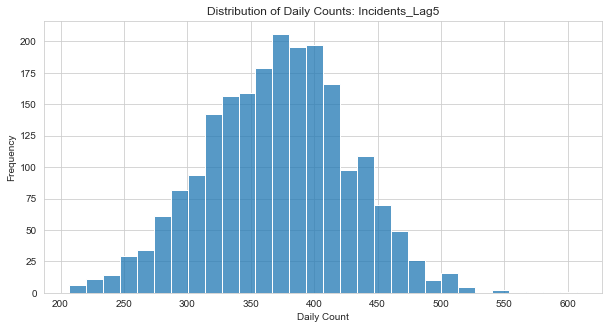

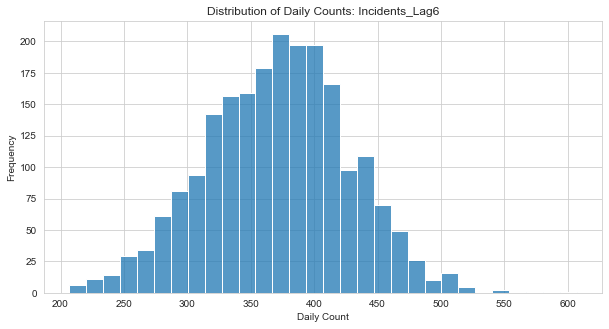

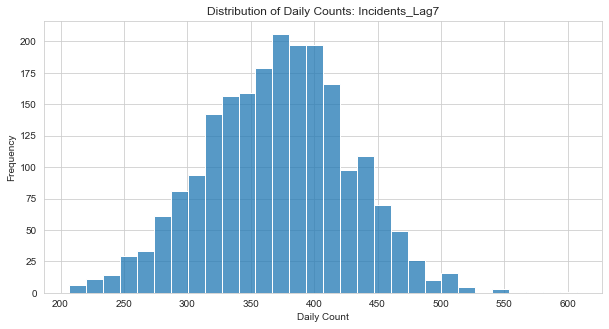

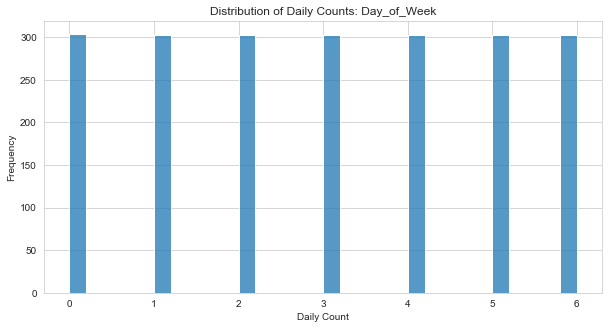

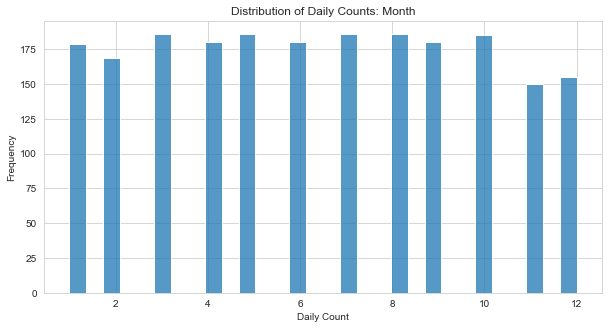

In [22]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

#Line plot of daily total incidents
plt.figure(figsize=(10, 5))
plt.plot(daily_totals.index, daily_totals['Total_Incidents_All'])
plt.title('Daily Total Incidents')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Histogram of daily total incidents
plt.figure(figsize=(10, 5))
sns.histplot(daily_totals['Total_Incidents_All'], bins=30, kde=True)
plt.title('Distribution of Daily Total Incidents')
plt.xlabel('Number of Incidents')
plt.ylabel('Frequency')
plt.show()

#Heatmap of the correlation between different incident types
plt.figure(figsize=(10, 10))
incident_types_corr = daily_totals.drop(columns=['Total_Incidents_All', 'Hotspot']).corr()
sns.heatmap(incident_types_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Different Incident Types')
plt.show()

#Bar plot of hotspot vs non-hotspot days
plt.figure(figsize=(6, 6))
sns.countplot(x=daily_totals['Hotspot'].dropna())
plt.title('Count of Hotspot vs Non-Hotspot Days')
plt.xlabel('Hotspot')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

#Filtering out non-incident type columns
incident_columns = [col for col in daily_totals.columns if col not in ['Total_Incidents_All', 'Hotspot']]

#Creating histograms for each incident type
for incident in incident_columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(daily_totals[incident], bins=30, kde=False)
    plt.title(f'Distribution of Daily Counts: {incident}')
    plt.xlabel('Daily Count')
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
daily_totals.to_csv('daily_totals.csv', index=False)